# Train and Validate Machine Learning Models

**Author:** Rana Elladki  
**Date:** November 20, 2025  

---

## Table of Contents
1. [Introduction](##1-introduction)
2. [Get Sample Dataset](#2-get-sample-dataset)
3. [Import Dependencies](#3-import-dependencies)
4. [Train and Validate Linear Regression](#4-train-and-validate-linear-regression)
5. [Train and Validate Artificial Neural Network](#5-train-and-validate-artificial-neural-network)
6. [Perform Statistical Analysis](#6-perform-statistical-analysis)
7. [Summary](#7-summary)

---


## 1. Introduction
In the eda.ipynb notebook, we performed exploratory data analysis (EDA) on our dataset by filtering outliers and applying log transformations to skewed data. Upon completion of EDA, we split the dataset into training, validation, and testing sets. Here we will use these datasets to train and evaluate our machine learning (ML) models. 
This notebook:
- Trains a linear regression model (LR). 
- Trains an artificial neural network (ANN).
- Performs a statistical analysis on both ML models.

For demonstration purposes, we will use a sample dataset contianing only 1000 molecules. The actual dataset contains ~134,000 molecules, so results from this notbook should not be used strictly to evaulate the entire dataset. 

Note that this notebook contains demonstrations and explanations for the code found in **train_lr.py**, **train_ann.py**, and **stats.py**.

In [65]:
import sys
sys.path.append("../src")

# import functions taht we need to get a sample dataset
from parse_xyz import parse_xyz_folder
from multiprocessing import Pool, cpu_count
import extract_desc
import eda
import copy
import pandas as pd
import numpy as np

## 2. Get Sample Dataset

In [66]:
data_dir = "../sample_data/"
df = parse_xyz_folder(data_dir, as_dataframe=True, check_cache=False)
# get small molecules only from dataset
mols_arr = extract_desc.get_small_molec(df)
# get atomic coordinates for molecules
coord_arr = extract_desc.get_atom_coords(df)

# build descriptor dict for all molecules

with Pool(processes=cpu_count()) as pool:
    all_desc = pool.map(extract_desc.process_molecule, zip(mols_arr, coord_arr))

# index it with SMILES
desc_df = pd.DataFrame(all_desc).set_index("SMILES")

Parsing all XYZ files in ../sample_data/ ...
Saving parsed data to ../sample_data/xyz_data.parquet ...


### Perform EDA and Split Dataset

In [67]:
# perform pearson coefficient correlation analysis to get a dataframe of only the top features
print("Performing Pearson correlation analysis...")
reduced_df = eda.pearson_correlation(copy.deepcopy(desc_df), top_count=5, draw=0)

# filter outliers
print("Filtering outliers...")
filtered_df = eda.filter_outliers(copy.deepcopy(reduced_df), draw=0)

# split the data into training/validation/test sets
print("Splitting data for ML...")
X_train, X_val, X_test, y_train, y_val, y_test = eda.split_data(filtered_df)

Performing Pearson correlation analysis...
Filtering outliers...
Splitting data for ML...


### Log Transform Skewed Features

In [68]:
# log transform skewed features to compare logged vs not logged 
print("Log transforming skewed features...")
X_train_logged = eda.log_transform(copy.deepcopy(X_train), skew_thresh=0.7, draw=0)
X_val_logged = eda.log_transform(copy.deepcopy(X_val), skew_thresh=0.7, draw=0)
X_test_logged = eda.log_transform(copy.deepcopy(X_test), skew_thresh=0.7, draw=0)
y_train_logged = copy.deepcopy(y_train)
y_val_logged = copy.deepcopy(y_val)
y_test_logged = copy.deepcopy(y_test)

Log transforming skewed features...


Now that we have our datasets, we can begin with training our models.

## 3. Import Dependencies

Begin by importing dependencies that we will use to train both our linear regression model and our artificial neural network.

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import shap

### Libraries:
- **sklearn.linear_model** -> LinearRegression
    
    Provides linear regression model
- **sklearn.neural_network** -> MLPRegressor
    
    Implements a feed-forward artificial neural network
- **sklearn.model_selection** -> GridSearchCV

    Performs hyperparameter tuning using cross-validation, to find the best model configuration
- **sklearn.preprocessing** -> StandardScaler

    Rescales input features for the artificial neural network
- **scipy.stats** -> pearsonr

    Computes perason correlation between true and predicted value
- **scipy.metrics** -> r2_square, mean_squared_error, mean_absolute_error, root_mean_squared_error

    Provides statistical metrics to evaluate model performance
- **prettytable** -> PrettyTable

    Library for printing a formatted table
- **matplotlib** -> pyplot

    Plotting library
 - **shap** -> SHAP (SHapley Additive exPlanations)

    Evaluate feature important in predictions using Shapley values.

## 4. Train and Validate Linear Regression

Now, we can train our linear regression model. We begin by initializing the model, and then fit it to the training data.

In [70]:
def train_lr(X_train, y_train):
    """
    Train and fit linear regression model.

    Parameters
    ----------
    X_train : pandas.DataFrame
        Input features for training set
    y_train : pandas.Series
        Target values for training set.
    
    Returns
    -------
    LinearRegression
        Trained and fitted linear regression model
    """
    # initiate linear regression model
    lr = LinearRegression()

    # fit the model with the training data
    lr.fit(X_train, y_train)

    return lr

Create a function to get predictions on validation/test set, and calculate statistics necessary to evaluate model performance. 

In [71]:
def test_lr(lr, X_test, y_test):
    """
    Validate linear regression model

    Parameters
    ----------
    lr : LinearRegression
        Trained and fitted linear regression model
    X_test : pandas.DataFrame
        Input features for test set 
    y_test : pandas.Series
        True target values for training set.

    Returns
    -------
    tuple :
        (y_test_pred, report), where :
            y_test_pred : numpy.ndarray
                Prediced target values
            report : dict
                Dictionary containing statistics on predicted data:
                    - "R2"  : float
                    - "RMSE": float
                    - "MSE" : float
                    - "MAE" : float
                    - "PC"  : float 
    """
    # get predictions on test set
    y_test_pred = lr.predict(X_test)
    # get pearson's rank correlation between true and predicted values
    pearson_corr = pearsonr(y_test, y_test_pred)[0]
    r2 = r2_score(y_test, y_test_pred) # get R^2 (coefficient of determination)
    rmse = root_mean_squared_error(y_test, y_test_pred) # get root mean squared error
    mse = mean_squared_error(y_test, y_test_pred) # get mean sequared error
    mae = mean_absolute_error(y_test, y_test_pred) # get mean absoltute error
    # save statistics to dictionary 
    report = {
        "R2": r2,
        "RMSE": rmse,
        "MSE": mse,
        "MAE": mae,
        "PC": pearson_corr
    }
    return y_test_pred, report

In [72]:
# Call train_lr on train datasets
lr_model = train_lr(X_train=X_train, y_train=y_train)

# Validate model on validation set and get statistics
val_stats = {} # empty dictionary to store validation statistics 
y_pred_val, report = test_lr(lr_model, X_val, y_val)
val_stats["LR"] = report

print(f"Pearson correlation: {val_stats["LR"]["PC"]:.3f}")

Pearson correlation: 0.850


The Pearson correlation is 0.85, which is pretty good. Since we train the model with the training set, without exposing it to the validation set, we would expect the test set have around the same Pearson correlation coefficient (PCC). 

We can also train a linear regression model with the logged features, to see if that would give a better Pearson correlation coefficient.

In [73]:
lr_log_model = train_lr(X_train=X_train_logged, y_train=y_train_logged)

# Validate model on logged validation set and get statistics
y_pred_val_log, report = test_lr(lr_log_model, X_val_logged, y_val_logged)
val_stats["LR Log"] = report

print(f"Pearson correlation: {val_stats["LR Log"]["PC"]:.3f}")

Pearson correlation: 0.799


Since the Pearson correlation coefficient is worse with the logged dataset, we will evaluate the not logged model on the testing set.

In [74]:
y_pred_test, report = test_lr(lr=lr_model, X_test=X_test, y_test=y_test)

test_stats = {} # empty dictionary to store test statistics 
test_stats["LR"] = report

## 5. Train and Validate Artificial Neural Network

Next, we can train and validate an atificial neural network. We begin by creating a function that initializes our model and finds the best hyperparameters in a defined parameter grid. This model will then be trained on the training and validation data, with a 5-fold cross validation.

In [75]:
def train_val_ann(X_train, X_val, y_train, y_val, rand_state=42):
    """
    Train and valid an artificial neural network using GridSearchCV.

    Parameters
    ----------
    X_train : pandas.DataFrame
        Input features for training set
    X_val : pandas.DataFrame
        Input features for validation set
    y_train : pandas.Series
        Target values for training set.
    y_val : pandas.Series
        Target values for valdiation set.
    rand_state : int, optional
        Random seed for MLPRegressor. Default is 42.

    Returns
    -------
    GridSearchCV
        GridSearchCV object containing the best fitted MLPRegressor model.
    """
    # combine train and validation set for cross validation
    X_comb = pd.concat([X_train, X_val], ignore_index=True)
    y_comb = pd.concat([y_train, y_val], ignore_index=True)

    # hyperparameter options for search
    param_grid = {'hidden_layer_sizes': [(10,), (10, 20), (20, 30), (10, 20, 30)],
                   'batch_size': [100, 200, 500],
                   'learning_rate_init': [0.01, 0.05, 0.1]}
    
    # define baseline MLP model
    ann = MLPRegressor(activation='relu', solver='adam', random_state=rand_state)

    # run grid search with 5-fold cross validation
    ann_gs = GridSearchCV(ann, param_grid, cv=5, verbose=1, scoring='r2', n_jobs=-1)
    ann_gs.fit(X_comb, y_comb)
    return ann_gs

We can then create a function to get the predictions for the validation/test set, and calculate the necessary statistics to evaluate the model's performance, similar to linear regression.

In [76]:
def test_ann(ann_gs, X_test, y_test):
    """
    Validate trained artificial neural network model

    Parameters
    ----------
    ann_gs : GridSearchV
        Fitted GridSearchCV object containing the best ANN model.
    X_test : pandas.DataFrame
        Input features for test set 
    y_test : pandas.Series
        True target values for testing set.

    Returns
    -------
    tuple :
        (y_test_pred, report), where :
            y_test_pred : numpt.ndarray 
                Prediced target values
            report : dict
                Dictionary containing statistics on predicted data
                    - "R2"  : float
                    - "RMSE": float
                    - "MSE" : float
                    - "MAE" : float
                    - "PC"  : float 
    """
    # get predictions on test set
    y_test_pred = ann_gs.predict(X_test)
    # get pearson's rank correlation between true and predicted values
    pearson_corr = pearsonr(y_test, y_test_pred)[0]
    r2 = r2_score(y_test, y_test_pred) # get R^2 (coefficient of determination)
    rmse = root_mean_squared_error(y_test, y_test_pred) # get root mean squared error
    mse = mean_squared_error(y_test, y_test_pred) # get mean sequared error
    mae = mean_absolute_error(y_test, y_test_pred) # get mean absoltute error
    # save statistics to dictionary 
    report = {
        "R2": r2,
        "RMSE": rmse,
        "MSE": mse,
        "MAE": mae,
        "PC": pearson_corr
    }
    return y_test_pred, report



In [77]:
# Call train_ann on testing and validation sets
ann_model = train_val_ann(X_train=X_train, X_val=X_val, y_train=y_train, 
                          y_val=y_val, rand_state=42) # define a random state for reproducalibility

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/mnt/home/elladki1/micromamba/envs/cmse802/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [78]:
# Validate model on validation set and get statistics 
y_pred_val_ann, report = test_ann(ann_gs=ann_model, X_test=X_val, y_test=y_val)
val_stats["ANN"] = report

print(f"Pearson correlation: {val_stats["ANN"]["PC"]:.3f}")

Pearson correlation: 0.850


The Pearson correlation is 0.85, indicating a strong correlation between the predicted and true target. Since we train the model with the training and validation sets, we would expect the Pearson correlation to drop slightly for the test set, since it has not been seen through the training process.

We can also train an artificial neural network model with the logged features, to see if that would give a better PCC. 

In [79]:
ann_log_model = train_val_ann(X_train=X_train_logged, X_val=X_val_logged,
                              y_train=y_train_logged, y_val=y_val_logged,
                              rand_state=42)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/mnt/home/elladki1/micromamba/envs/cmse802/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/home/elladki1/micromamba/envs/cmse802/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/home/elladki1/micromamba/envs/cmse802/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/home/elladki1/micromamba/envs/cmse802/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

In [80]:
# Validate model on logged validation set and get statistics 
y_pred_val_log_ann, report = test_ann(ann_log_model, X_test_logged, y_test_logged)
val_stats["ANN Log"] = report

print(f"Pearson correlation: {val_stats["ANN Log"]["PC"]:.3f}")

Pearson correlation: 0.789


The PCC is worse with the logged dataset. Another method we can try is applying a standard scaler. 

Note that the model did not converge while training the artificial neural network. This is due to the small dataset that we are testing. The model is still usable, but the loss has not be minimized. This issue dissappears when training on the entire dataset. 

In [81]:
# Initialize standard scaler
scaler = StandardScaler()

# Apply standard scaler to feature datasets
X_train_scaled = pd.DataFrame(scaler.fit_transform(copy.deepcopy(X_train)),
                              columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.fit_transform(copy.deepcopy(X_val)),
                            columns=X_val.columns)

# We do not apply the scaler to the target dataset
y_train_scaled = copy.deepcopy(y_train)
y_val_scaled = copy.deepcopy(y_val)

In [82]:
# Train ANN on scaled dataset
ann_gs_scaled = train_val_ann(X_train=X_train_scaled, X_val=X_val_scaled,
                              y_train=y_train_scaled, y_val=y_val_scaled,
                              rand_state=42)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/mnt/home/elladki1/micromamba/envs/cmse802/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/home/elladki1/micromamba/envs/cmse802/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/home/elladki1/micromamba/envs/cmse802/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/home/elladki1/micromamba/envs/cmse802/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

In [83]:
# Validate model on scaled validation set and get statistics
y_pred_val_scaled_ann, report = test_ann(ann_gs=ann_gs_scaled, X_test=X_val_scaled, y_test=y_val_scaled)
val_stats["ANN Scaled"] = report

print(f"Pearson correlation: {val_stats["ANN Scaled"]["PC"]:.3f}")

Pearson correlation: 0.912


The PCC is 0.912 with the scaled dataset, which is higher than the unscaled and logged datasets. Therefore, we will evaluate the scaled model on the testing set.

In [84]:
# Test scaled ANN on test set

# Scale test set
X_test_scaled = pd.DataFrame(scaler.fit_transform(copy.deepcopy(X_test)),
                             columns=X_test.columns)
y_test_scaled = copy.deepcopy(y_test)

# Test scaled model
y_pred_test_scaled_ann, report = test_ann(ann_gs=ann_gs_scaled,
                                          X_test=X_test_scaled,
                                          y_test=y_test_scaled)
test_stats["ANN Scaled"] = report

## 6. Perform Statistical Analysis

As part of the training process, we calculated statistical parameters to evaluate the model's performance. The results were stored in val_stats and test_stats dictionaries. 

We can define a function to print these results into a readible table.

In [85]:
def populate_table(dict, table):
    """
    Populate a Prettytable with model performance metrics

    Parameters
    ----------
    dict : dict
        Dictionary of dictionaries where the keys encode model type and scaling,
        and the values are dictionaries of statistical metrics R2, RMSE, MSE, MAE, 
        and PC.
    table : PrettyTable
        PrettyTable object to add rows to.

    Returns
    -------
    PrettyTable 
        The updated Prettytable with populated rows. 
    """
    stats_metrics = ["R2", "RMSE", "MSE", "MAE", "PC"]
    # Loop through the dictionary and populate the table
    for key, metrics in dict.items():
        # Extract model type and scaling method from dictionary key string
        parts = key.split(maxsplit=1)
        # Print LR as Linear Regression and ANN as artificial neural network for readability
        if parts[0]=="LR":
            model = "Linear Regression (LR)"
        elif parts[0]=="ANN":
            model = "Artificial Neural Network (ANN)"
        else:
            model = 'NaN'
        
        scaling = parts[1] if len(parts) > 1 else "--"

        row_vals = []

        # Add row with formatted values (e.g., 3 decimal places)
        for stat in stats_metrics:
            if stat in metrics:
                row_vals.append(f"{metrics[stat]:.3f}")
            else:
                # If metric is missing, print NaN in row
                row_vals.append("--")

        table.add_row([model, scaling] + row_vals)

    return table 

def create_table(valid_dict, test_dict):
    """
    Create a PrettyTable summarizing validation and test model metrics

    Parameters
    ----------
    valid_dict : dict
        Dictionary of validation metrics for different models and scalings.
    test_dict : dict
        Dictionary of test metrics for different models and scalings
    
    Returns
    -------
    PrettyTable
        A formatted PrettyTable containing statatistics for validation and test sets.
    """
    # Create table with headers
    table = PrettyTable(["Model", "Scaling", "R²", "RMSE", "MSE", "MAE", "PC"])

    table.add_row(["--- VALIDATION SET ---", "", "", "", "", "", ""])
    # Loop through the dictionary and populate the table with validation statistics
    populate_table(valid_dict, table)
    
    table.add_row(["--- TESTING SET ---", "", "", "", "", "", ""])
    # Loop through the dictionary and populate the table with testing statistics
    populate_table(test_dict, table)

    return table

In [86]:
# Print table of validation and testing statistics
print(create_table(val_stats, test_stats))

+---------------------------------+---------+-----------+--------+----------+--------+-------+
|              Model              | Scaling |     R²    |  RMSE  |   MSE    |  MAE   |   PC  |
+---------------------------------+---------+-----------+--------+----------+--------+-------+
|      --- VALIDATION SET ---     |         |           |        |          |        |       |
|      Linear Regression (LR)     |    --   |   0.719   | 0.552  |  0.304   | 0.396  | 0.850 |
|      Linear Regression (LR)     |   Log   |   -3.689  | 2.254  |  5.080   | 2.111  | 0.799 |
| Artificial Neural Network (ANN) |    --   |   0.722   | 0.549  |  0.301   | 0.402  | 0.850 |
| Artificial Neural Network (ANN) |   Log   | -3242.684 | 53.715 | 2885.255 | 52.926 | 0.789 |
| Artificial Neural Network (ANN) |  Scaled |   0.819   | 0.442  |  0.196   | 0.334  | 0.912 |
|       --- TESTING SET ---       |         |           |        |          |        |       |
|      Linear Regression (LR)     |    --   |   0.

We can see from the table that the un-logged linear regression and scaled artificial neural network perform the best. If the $R^2$ value blew up past 1 or below 0, it indicated that the model did not converge, so we should not be using these models. 

We can also compare the precited to actual radius of gyration for the best models through plots.

In [87]:
def plot_true_pred(ax, y_true, y_pred, plt_label=None):
    """
    Plot true versus predicted values use a hexbin density map.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes object to plot on.
    y_true : array-like
        Array of true target values.
    y_pred : array-like
        Array of predicted target values
    plt_lable : str, optional
        Optional lable to place on the top-left of the plot.
    
    Returns
    -------
    None
    """
    # Determine plot limits based on the min/max of true/predicted values
    x_range = [min(np.min(y_true), np.min(y_pred)), max(np.max(y_true), np.max(y_pred))]
    y_range = [min(np.min(y_true), np.min(y_pred)), max(np.max(y_true), np.max(y_pred))]
    
    # Use hexbin to visualize point density instead of scatter
    hb = ax.hexbin(y_true, y_pred, gridsize=30, cmap='viridis', mincnt=1)
    cb = plt.colorbar(hb)
    cb.set_label("Number of Points")
    ax.set_xlabel('True Val')
    ax.set_ylabel('Predicted Val')
    ax.plot(x_range, y_range, 'r--')
    ax.grid()
    if plt_label is not None:
        ax.text(
            0.05, 0.95, plt_label, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )


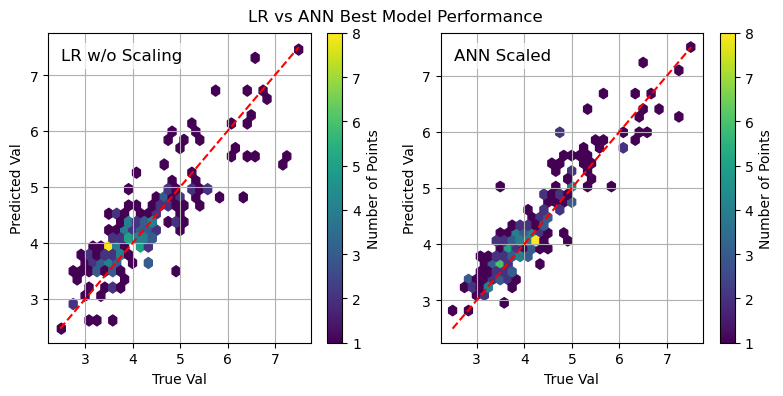

In [88]:
# Define datasets to plot
data_sets = [
    (y_test, y_pred_test, "LR w/o Scaling"),
    (y_test_scaled, y_pred_test_scaled_ann, "ANN Scaled")
]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes = axes.flatten()

# Plot each dataset
for ax, (x, y, label) in zip(axes, data_sets):
    plot_true_pred(ax, x, y, label)
plt.tight_layout()
fig.suptitle("LR vs ANN Best Model Performance")
plt.subplots_adjust(top=0.92) # adjust to make room for title 
plt.show()

From the plots above, we can see that the data with the ANN is closer to the the true value, as seen by the clustering around y=x.

Lastly, we can evaluate the impact of the physicochemical descriptors on RG2. We can generate the weight of the coefficients in the linear regression model through a bar plot, and conduct a SHAP analysis for the artificial neural network model.

The functions below have been modified to print plots to screen rather than save to specified output directory, as in the stats.py file.

In [91]:
def lr_coef_weights(model, feats):
    """
    Plot and save linear regression feature coefficients bar plot.

    Parameters
    ----------
    model : sklearn.linear_model
        Trained linear regression model.
    feats : list of str
        List of feature names corresponding to model coefficients.
    
    Returns
    -------
    None
    """
    coef_df = pd.DataFrame({'Feature': feats, 'Coefficient': model.coef_})
    
    # Sort by absolute coefficient value in decending order
    #   Sorting by absolute magnitude to highlight strongest contributors
    coef_df['Abs_Coef'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values('Abs_Coef', ascending=False).reset_index(drop=True)
    
    # Create a visual to compare feature coefficients
    plt.bar(coef_df['Feature'], coef_df['Coefficient'])
    # Rotated x-axis labels for readability
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Coefficient Value')
    plt.title('Linear Regression Feature Coefficients')
    plt.tight_layout()
    plt.show()

def ann_shap_analysis(model, X_train, X_test, sample=500):
    """
    Run SHAP analysis on neural network model and save a summary plot.

    Parameters
    ----------
    model : sklearn.neural_network
        Trained artificial neural network model.
    X_train : pandas.DataFrame
        Training data used to initialize SHAP explainer.
    X_test : pandas.DataFrame
        Testing data to use a subset of for SHAP analysis.

    Returns
    -------
    None
    """
    # Create a SHAP explainer for the model
    explainer = shap.Explainer(model.predict, X_train)

    # Calculate SHAP values for the test set (sample 500 points)
    #   sample points randomly chosen to reduce computation time
    sample_indices = np.random.choice(X_test.shape[0], sample, replace=False)
    X_test_sample = X_test.iloc[sample_indices]
    shap_vals = explainer(X_test_sample).values
    
    # Generate SHAP summary plot showing feature importance and impact
    plt.figure()
    shap.summary_plot(shap_vals, X_test_sample, feature_names=X_test.columns)
    plt.show()

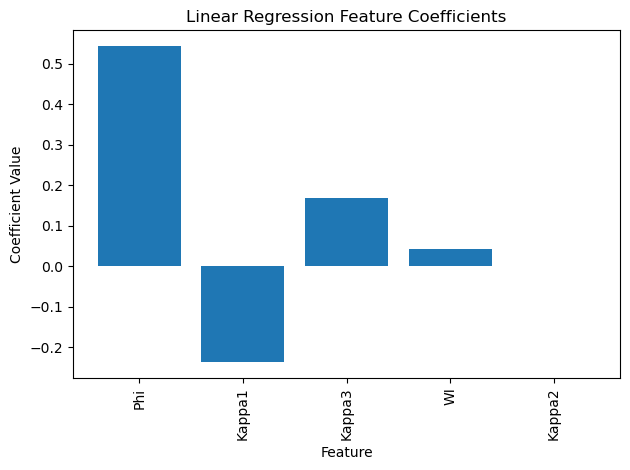

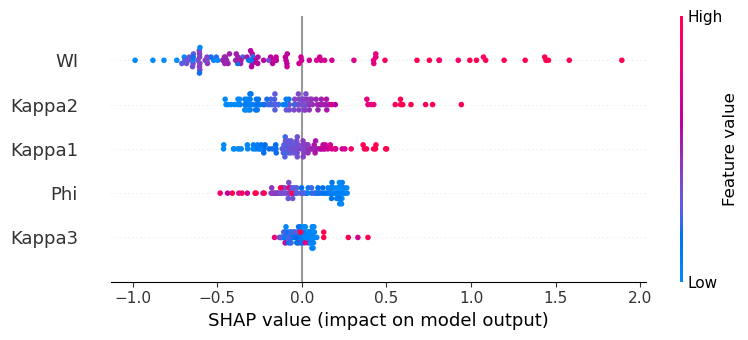

In [93]:
# Generate coefficient values plots for linear model for best R^2
lr_coef_weights(lr_model, X_train.columns)

# Perform SHAP analysis for artificial neural network model with best R^2
ann_shap_analysis(ann_gs_scaled, X_train_scaled, X_test_scaled, sample=100)

It looks like the Wiener Index (WI) has the highest SHAP value for the ANN, but a much lower coefficient in the linear model. This could be due to the WI not having a linear relationship with RG2, causing it to have a lower coefficient weight with the LR model. A similar explanation can be applied to the other features, such as Kappa2.

## 7. Summary

This notebook guided the process for training linear regression models and artificial neural networks, as well as identifying their performance. First we imported a sample dataset of 1000 molecules, that was split into training, validation, and testing sets. Then, we trained and validation two linear regression models, one with logged features. The un-logged model performed better, so we used it to get the predictions on the testing set. Next, we trained and validated three artificial neural networks: un-scaled, logged, and scaled with standard scaler. The model trained on the datasets scaled with a standard scaler showed the best predictions on the validation set, so we used it to get the predictions on the testing set. We then conducted a statistical analysis on the validation sets and the test sets, where we saw that the scaled artificial neural network has the best performance. Lastly, we evaluated feature importance by plotting the coefficient weights in the linear regression model and perfoming a SHAP analysis for the scaled ANN. We can see that Phi was the most impactful feature for LR, while the WI was the most impactful for the scaled ANN.  